<a href="https://colab.research.google.com/github/mannixp/CHIST/blob/main/PDF_Construction_using_extruded_mesh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
!apt-get update --fix-missing

try:
    import firedrake
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/firedrake-install-real.sh" -O "/tmp/firedrake-install.sh" && bash "/tmp/firedrake-install.sh"
    import firedrake

**Part 4 - Composing functions** 

The available potential energy (APE) of a buoyancy field $B(\mathbf{x})$ of vertical extent $Z(\mathbf{x})$ is given by the difference of its potential energy (PE) and the background or refrence potential energy 
\begin{equation}
\mathbb{E}[BZ^*]  - \mathbb{E}[BZ] = \iint b \left(Z^*(b) -z \right) \; f_{BZ}(b,z) \; dbdz,
\end{equation}
where the reference state
\begin{equation}
Z^*(b) = F^{-1}_Z \circ F_B(b) = Q_Z \circ F_B(b),
\end{equation}
corresponds to an adiabatic volume preserving rearrangement of the fluid into a state that minimises PE. To calculate this quantity therefore requires an estimation of the buoyancy's PDF $f_B$, CDF $F_B$, the vertical cordinate's QDF $Q_Z = F_Z^{-1}$ and an ability to compose these functions. In this notebook we explain how the composition of functions is achieved by *NumDF*.

As an example of a buoyancy field and potential we will consider
\begin{align}
    B(x_1,x_2) &= x_2(1 - x_2)/2,\\
    Z(x_1,x_2) &= x_2,
\end{align}
such that the physical domain is given by $\Omega_X \in [-1,1] \times [0,1]$, the buoyancy domain $\Omega_B \in [0,1/8]$ and that of the potential by $\Omega_Z \in [0,1]$. 

To construct the buoyancy's PDF & CDF $f_B,F_B$ and the vertical cordinate's QDF $F_Z^{-1}$ we make use of the **Ptp** class imported below.

In [11]:
from numdf import Ptp
from firedrake import *
from firedrake.__future__ import interpolate

We first set up the domain of the buoyancy $B$

In [12]:
ptp_B = Ptp(Omega_X={'x1': (-1, 1),'x2': (0, 1)}, Omega_Y={'Y': (0, 1/8)}, n_elements=50)

Using this domain we then compute the CDF and PDF of the buoyancy field, by calling the fit method.

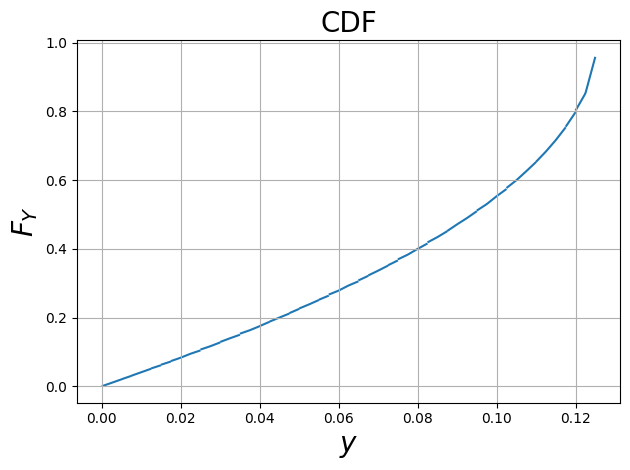

In [13]:
# Construct the PDF,CDF,QDF
x1,x2 = ptp_B.x_coords()
density_B = ptp_B.fit(Y=(x2/2)*(1 - x2), quadrature_degree=400) 
density_B.plot(function='CDF')

To obtain the QDF of the co-ordinate field $Z$ we follow a similar procedure.

In [14]:
# Set the domain & function space
ptp_Z = Ptp(Omega_X={'x1': (-1, 1),'x2': (0, 1)}, Omega_Y={'Y': (0, 1)}, n_elements=10)

# Construct the PDF,CDF,QDF
x1,x2 = ptp_Z.x_coords()
density_Z = ptp_Z.fit(Y=x2, quadrature_degree=100)

Having obtained all necessary functions it remains to obtain the reference height $Z^*(b)$ and evaluate the integral to compute the APE. To obtain the reference height we construct a function Z_ref as below using a quadrature element. At the nodes of the quadrature element we shall evaluate the function composition $Z^*(b) = Q_Z \circ F_B(b)$.

In [15]:
# Define a function space for Z_ref
quadrature_degree = 10

mesh_F = density_B.cdf.function_space().mesh()
mesh_Q = density_Z.qdf.function_space().mesh()

V_ZE    = FiniteElement(family="Quadrature",cell="interval",degree=quadrature_degree,quad_scheme='default')
V_Z     = FunctionSpace(mesh=mesh_F ,family=V_ZE)
Z_ref   = Function(V_Z)

With the quadrature element defined we now grab the quadrature points $b_q$

In [16]:
# First, grab the mesh.
m = V_Z.mesh()

# Now make the VectorFunctionSpace corresponding to V_Z.
W = VectorFunctionSpace(m, V_Z.ufl_element())

# Next, interpolate the coordinates onto the nodes of W.
X = assemble(interpolate(m.coordinates, W))

We now avail of a vertex only mesh in order to compute $F_q = F_B(b_q)$, the CDF evaluated at the quadrature points $b_q$. 

In [17]:
b_q = [ [b_i,] for b_i in X.dat.data[:]]
vom = VertexOnlyMesh(mesh_F, b_q)

# P0DG is the only function space you can make on a vertex-only mesh
P0DG = FunctionSpace(vom, "DG", 0)

# Interpolation performs point evaluation
F = assemble(interpolate(density_B.cdf, P0DG))

And using the same methods again we compute $Q_q = Q_Z(F_q)$, QDF evaluated at the points $F_q = F_B(b_q)$.

In [18]:
F_q = [ [F_i,] for F_i in F.dat.data[:]]
vom = VertexOnlyMesh(mesh_Q, F_q)

# P0DG is the only function space you can make on a vertex-only mesh
P0DG = FunctionSpace(vom, "DG", 0)

# Interpolation performs point evaluation
# [test_vertex_only_mesh_manual_example 2]
Q_q = assemble(interpolate(density_Z.qdf, P0DG))

Finally we parse these values into the dofs of Z_ref

In [19]:
Z_ref.dat.data[:] = Q_q.dat.data[:]

To evaluate the background potential energy or BPE we can then integrate the expression
\begin{equation}
\mathbb{E}[BZ^*] = \int b Z^*(b) f_{B}(b) \; db
\end{equation}
as implemented below

In [20]:
# Calculate the BPE
b = density_B.y
f = density_B.pdf
BPE = assemble( Z_ref*b*f*dx(degree=quadrature_degree) )

# Calculate the TPE
V   = 2
TPE = (1/V)*assemble( x2*.5*(x2-x2**2)*dx ) # IC

# Calculate the APE
print('APE = ',BPE - TPE)

APE =  0.005302123198117702
